# Homework 04 - Applied ML

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt  
from sklearn import preprocessing
%matplotlib inline

## 1. Predict the skin color of a soccer player

In this first task we train a *Random forest* classifier to be able to predict the skin color of a soccer player. In order to do so, we proceed pre-processing the data as first step then moving toward the choice of the model (interpret as the choice of parameters controlling the possible issues i.e. the *overfitting*). As required, we then switch to the inspection of the `feature_importances_` attribute and the discussion of the obtained results.

### 1.1 Exploratory Data Analysis, Feature Selection and Feature engineering

In [35]:
# Import data 
data = pd.read_csv('CrowdstormingDataJuly1st.csv', sep = ',')

In [36]:
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [37]:
data.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')

##### First clean of data
According to the given information in the [data description](https://github.com/ADAEPFL/Homework/blob/master/04%20-%20Applied%20ML/DATA.md), we get rid off all the dyads that correspond to players whose picture is not available.

In [38]:
data_clean = data[(data.photoID.notnull())]

##### Have a glance at the labels

Thus, we check whether happens that one of the two raters do not assign the label. We see that both of them do their job. 

In [39]:
# How many players the rater 1 don't label?
miss_rater_1 = sum(data_clean.rater1.isnull())
# How many the rater 2?
miss_rater_2 = sum(data_clean.rater2.isnull())

print ('Rater 1 does not label', miss_rater_1, 'players')
print ('Rater 2 does not label', miss_rater_2, 'players')

Rater 1 does not label 0 players
Rater 2 does not label 0 players


We study the distribution of the labels, even to verify disagreements between the two raters. The procedure consist of:
- Grouping by the `playerShort`
- Get the given labels
- Plot their distribution using a *simple* barplot

In [40]:
player_data = data_clean.groupby('playerShort')

Verify that all the players only belong to one club

In [41]:
player_data.agg({'club' : lambda x: len(set(x))})['club'].unique()

array([1])

In [42]:
player_data.agg({'position' : lambda x: len(set(x))})['position'].unique()

array([1])

In [43]:
players = player_data.agg({
        'club' : 'first',
        'leagueCountry' : 'first',
        'birthday' : 'first',
        'height' : 'first',
        'weight' : 'mean',
        'position' : 'first',
        'games' : 'sum',
        'victories' : 'sum',
        'ties' : 'sum',
        'defeats' : 'sum',
        'goals' : 'sum',
        'yellowCards': 'sum',
        'yellowReds': 'sum',
        'redCards' : 'sum',
        'rater1' : 'mean',
        'rater2' : 'mean',
        'refNum' : 'count',
        'refCountry' : 'count',
        'meanIAT' : 'mean',
        'meanExp' : 'mean'
        
    })

In [44]:
players

,victories,weight,club,yellowCards,birthday,meanExp,position,defeats,goals,redCards,games,ties,rater2,refCountry,meanIAT,rater1,yellowReds,height,leagueCountry,refNum
playerShort,,,,,,,,,,,,,,,,,,,,
aaron-hughes,247,71.0,Fulham FC,19,08.11.1979,0.494575,Center Back,228,9,0,654,179,0.00,166,0.346459,0.25,0,182.0,England,166
aaron-hunt,141,73.0,Werder Bremen,42,04.09.1986,0.449220,Attacking Midfielder,122,62,1,336,73,0.25,99,0.348818,0.00,0,183.0,Germany,99
aaron-lennon,200,63.0,Tottenham Hotspur,11,16.04.1987,0.491482,Right Midfielder,115,31,0,412,97,0.25,101,0.345893,0.25,0,165.0,England,101
aaron-ramsey,150,76.0,Arsenal FC,31,26.12.1990,0.514693,Center Midfielder,68,39,1,260,42,0.00,104,0.346821,0.00,0,178.0,England,104
abdelhamid-el-kaoutari,41,73.0,Montpellier HSC,8,17.03.1990,0.335587,Center Back,43,1,2,124,40,0.25,37,0.331600,0.25,4,180.0,France,37
abdou-traore_2,41,74.0,Girondins Bordeaux,11,17.01.1988,0.296562,Right Midfielder,33,3,0,97,23,0.75,42,0.320079,0.75,1,180.0,France,42
abdoulaye-diallo_2,8,80.0,Stade Rennes,0,30.03.1992,0.400818,Goalkeeper,8,0,0,24,8,1.00,20,0.341625,0.75,0,189.0,France,20
abdoulaye-keita_2,0,83.0,Girondins Bordeaux,0,19.08.1990,0.417225,Goalkeeper,2,0,0,3,1,1.00,2,0.355406,0.75,0,188.0,France,2
abdoulwhaid-sissoko,34,68.0,Stade Brest,21,20.03.1990,0.429630,Defensive Midfielder,62,3,2,121,25,1.00,56,0.348178,1.00,0,180.0,France,56


In [45]:
label_1 = players['rater1']

In [46]:
label_2 = players['rater2']

In [47]:
players.drop('rater1', axis = 1, inplace = True)

In [48]:
players.drop('rater2', axis= 1, inplace = True)

### Baseline model

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
from sklearn.utils import shuffle

In [18]:
from sklearn.multioutput import MultiOutputClassifier

#### Preprocess variable to be used as input for the classifier

In [49]:
players['birthday'] = players['birthday'].apply(lambda x: float(x.split('.')[-1]))

In [50]:
def encode_string_variable(df, attribute):
    
    df[attribute] = df[attribute].fillna('Unknown')
    
    le = preprocessing.LabelEncoder()
    
    le.fit(df[attribute])
    
    df[attribute] = le.transform(df[attribute]) 

In [51]:
# Get the string variables
object_features = [i for i in players.columns if players[i].dtypes == 'object']
numerical_features = [i for i in players.columns if players[i].dtypes == 'int64' or players[i].dtypes == 'float64']

In [52]:
for feature in object_features:
    encode_string_variable(players, feature)

##### Categorise features

In [34]:
players.dtypes

victories          int64
weight           float64
club               int64
yellowCards        int64
birthday         float64
meanExp          float64
position           int64
defeats            int64
goals              int64
redCards           int64
games              int64
ties               int64
refCountry         int64
meanIAT          float64
yellowReds         int64
height           float64
leagueCountry      int64
refNum             int64
dtype: object

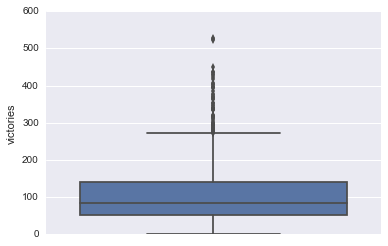

In [54]:
sns.boxplot(players[numerical_features[0]], orient='v')

In [91]:
def categorise_numerical_features(df, attribute):
    
    minimum, minimum_wisker, first_quartile, median, third_quartile, maximum_wisker, maximum = get_statistics_numerical_values(df, attribute)
    for x in df[attribute]:
        if x <= minimum:
            x = 0
        elif minimum < x <= first_quartile:
            x = 1
        elif first_quartile < x <= median:
            x = 2
        elif median < x <= third_quartile:
            x = 3
        elif third_quartile < x <= maximum:
            x = 4
        else:
            x = 5    

In [73]:
#players.describe()['victories']
B=plt.boxplot(players['victories'])
plt.close()
min_max = [item.get_ydata()[1] for item in B['whiskers']]

In [84]:
def get_statistics_numerical_values(df, attribute):
    
    feature_boxplot = plt.boxplot(players['victories'])
    plt.close()#[[3,4,5,6,7]]
    min_max = [item.get_ydata()[1] for item in feature_boxplot['whiskers']]
    
    minimum = df[attribute].quantile(0)
    minimum_wisker = min_max[0]
    first_quartile = df[attribute].quantile(0.25)
    median = df[attribute].quantile(0)
    third_quartile = df[attribute].quantile(0.75)
    maximum_wisker = min_max[1]
    maximum = df[attribute].quantile(1)
    
    return (minimum, minimum_wisker, first_quartile, median, third_quartile, maximum_wisker, maximum)
    

In [94]:
players['victories'] = categorise_numerical_features(players, 'victories')

In [95]:
players['victories']

playerShort
aaron-hughes              None
aaron-hunt                None
aaron-lennon              None
aaron-ramsey              None
abdelhamid-el-kaoutari    None
abdou-traore_2            None
abdoulaye-diallo_2        None
abdoulaye-keita_2         None
abdoulwhaid-sissoko       None
abdul-rahman-baba         None
abdul-razak               None
abel-aguilar              None
abelaziz-barrada          None
abou-diaby                None
adam-bodzek               None
adam-campbell             None
adam-federici             None
adam-hlousek              None
adam-johnson              None
adam-morgan               None
adam-pinter               None
adam-smith_3              None
adam-szalai               None
adan                      None
adel-taarabt              None
adil-rami                 None
adrian-colunga            None
adrian-mutu               None
adrian_2                  None
adrian_7                  None
                          ... 
xisco_2                   N

In [70]:
players.describe()['victories'][[3,4,5,6,7]]

/Users/cristinamenghini/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


min      0.0
25%     52.0
50%     85.0
75%    140.0
max    527.0
Name: victories, dtype: float64

#### Split train and test

In [78]:
from sklearn.model_selection import train_test_split

In [104]:
X_train, X_test, y_train, y_test = train_test_split(players, label_1, test_size=0.33, random_state=42)

In [105]:
forest = RandomForestClassifier(n_estimators=100, random_state=1)

In [106]:
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)

In [107]:
multi_target_forest.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').